In [1]:
#aggregate spaghetti plots of the target for 
#non-business and business users over the 24 hours of all days

In [2]:
import pandas as pd
import os

In [3]:
data_head = r"C:\Users\Joe\Documents\Project Programming\enefit\predict-energy-behavior-of-prosumers\data"
data_file = 'train.csv'
df = pd.read_csv(os.path.join(data_head,data_file))

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime']

0         2021-09-01 00:00:00
1         2021-09-01 00:00:00
2         2021-09-01 00:00:00
3         2021-09-01 00:00:00
4         2021-09-01 00:00:00
                  ...        
2018347   2023-05-31 23:00:00
2018348   2023-05-31 23:00:00
2018349   2023-05-31 23:00:00
2018350   2023-05-31 23:00:00
2018351   2023-05-31 23:00:00
Name: datetime, Length: 2018352, dtype: datetime64[ns]

In [5]:
df['Time of Day']=df['datetime'].dt.hour

In [14]:
cons_bool = 0
mean_df = pd.DataFrame(df[df['is_consumption']==cons_bool].groupby(['is_business','Time of Day'])['target'].mean())
std_df = pd.DataFrame(df[df['is_consumption']==cons_bool].groupby(['is_business','Time of Day'])['target'].std())

In [15]:
pivot_mean_df = pd.pivot_table(mean_df.reset_index(),values='target',index='Time of Day',columns='is_business')
pivot_std_df = pd.pivot_table(std_df.reset_index(),values='target',index='Time of Day',columns='is_business')
pivot_mean_df

is_business,0,1
Time of Day,,
0,0.408370,1.141318
1,0.365576,1.132825
2,0.331051,1.118118
3,0.302942,1.141365
4,0.355534,1.200843
5,1.833283,2.563595
6,8.918230,8.364271
7,30.295718,27.177301
8,79.842062,68.698138


In [16]:
pivot_dist_df = pivot_mean_df.copy()
z=1.96 #95% confidence interval
businesses = ((df['is_business']==1)&(df['is_consumption']==cons_bool)).sum()
nonbusinesses = df[df['is_consumption']==cons_bool].shape[0]-businesses

businesses/=24 #assuming equal number of businesses per hour
nonbusinesses/=24

pivot_dist_df['business_lower_range'] = pivot_mean_df[1] - z*pivot_std_df[1]/(businesses**0.5)
pivot_dist_df['business_upper_range'] = pivot_mean_df[1] + z*pivot_std_df[1]/(businesses**0.5)
pivot_dist_df['nonbusiness_lower_range'] = pivot_mean_df[0] - z*pivot_std_df[0]/(nonbusinesses**0.5)
pivot_dist_df['nonbusiness_upper_range'] = pivot_mean_df[0] + z*pivot_std_df[0]/(nonbusinesses**0.5)
pivot_dist_df=pivot_dist_df.clip(0)
pivot_dist_df

is_business,0,1,business_lower_range,business_upper_range,nonbusiness_lower_range,nonbusiness_upper_range
Time of Day,,,,,,
0,0.408370,1.141318,1.058166,1.224471,0.391486,0.425253
1,0.365576,1.132825,1.049764,1.215886,0.350820,0.380332
2,0.331051,1.118118,1.035390,1.200847,0.313934,0.348168
3,0.302942,1.141365,1.057651,1.225078,0.290935,0.314948
4,0.355534,1.200843,1.116888,1.284797,0.341890,0.369178
5,1.833283,2.563595,2.408282,2.718909,1.725383,1.941184
6,8.918230,8.364271,7.896552,8.831991,8.426321,9.410138
7,30.295718,27.177301,25.780846,28.573757,28.864063,31.727374
8,79.842062,68.698138,65.527486,71.868790,76.555186,83.128938


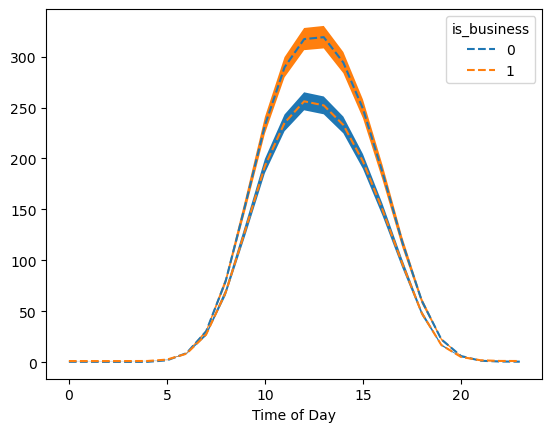

In [17]:
import matplotlib.pyplot as plt
pivot_mean_df.plot(linestyle='--')
plt.fill_between(pivot_dist_df.index,pivot_dist_df['business_lower_range'],pivot_dist_df['business_upper_range'])
plt.fill_between(pivot_dist_df.index,pivot_dist_df['nonbusiness_lower_range'],pivot_dist_df['nonbusiness_upper_range'])